In [1]:
from posixpath import split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import time
import shutil
import os


In [2]:
def calculate_k_bb(df):
    k_cols = []
    bb_cols = []
    for col in df.columns:
        print(col)
        if ("k%_" in col and "bb%_" not in col):
            k_cols.append(col)
        elif ("bb%_" in col and "k%_" not in col):
            bb_cols.append(col)
        else:
            print("NOT A MODEL OUTPUT COLUMN")
    df["k% mods"] = df[k_cols].mean(axis=1) 
    df["bb% mods"] = df[bb_cols].mean(axis=1)
    df["k-bb act"] = df["k%"] - df["bb%"]
    df["k-bb mods"] = df["k% mods"] - df["bb% mods"]
    df["k-bb diff"] = df["k-bb mods"] - df["k-bb act"] 
    df["w_k_bb"] = df["k% mods"]-0.3*df["bb% mods"]
    df["k/bb act"] = df["k%"] / df["bb%"]
    df["k/bb mods"] = df["k% mods"] / df["bb% mods"]
    df["k/bb diff"] = df["k/bb mods"] - df["k/bb act"] 
    return df

def evaluate_model(model, X_test, y_test, target_variable):
    if 'xgb' in target_variable.lower():
        print("XGB MODEL")
    elif 'poly' in target_variable.lower():
        poly = model.named_steps['poly']
        model = model.named_steps['regressor']
        X_test = poly.transform(x_test)
    else:
        print("Model type not recognized try again")
    
    # Make predictions
    y_preds = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)

    # Print evaluation metrics
    print(f"Evaluation metrics for {target_variable}:")
    print(f"Model Type {model}:")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2) Score:", r2)
    print()
    
    return y_preds
    
    
def polynomial_learning(X, y, target_variable):
    # Pipeline definition
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=True)),
        ('regressor', Lasso())  # Initial regressor, will be replaced later
    ])
    
    # Parameter grid
    param_grid = {
        'regressor': [Lasso(), Ridge()],  # Regressors to try
        'poly__degree': [1, 2, 3, 4],  # Degrees to try
        'poly__interaction_only': [False],
        'regressor__alpha': [0.001, 0.01, 0.1, 0.25, 1.0, 2.5, 5, 10.0, 20]  # Alphas to try
    }

    # GridSearchCV object
    model = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=4)
    
    # Fit the model
    model.fit(X, y)
    
    # Extract best estimator and regressor
    best_estimator = model.best_estimator_
    best_regressor = best_estimator.named_steps['regressor']

    # Determine the best regressor type
    if isinstance(best_regressor, Lasso):
        print(f"Best regressor for {target_variable}: Lasso")
    elif isinstance(best_regressor, Ridge):
        print(f"Best regressor for {target_variable}: Ridge")
    else:
        print(f"Unknown best regressor for {target_variable}")

    # Extract polynomial features and regressor
    poly = best_estimator.named_steps['poly']
    regress = best_estimator.named_steps['regressor']

    # Print best score
    print(f"BEST SCORE for {target_variable}: {-model.best_score_}")

    # Transform features using the best estimator
    X_poly = poly.transform(X)
    
    # Fit the model on polynomial features
    regress.fit(X_poly, y)
    
    # Print coefficients and best parameters
    print("Coefficients:", regress.coef_)
    print(f"Best training parameters for {target_variable}: ", regress.get_params())

    #feature_names = poly.get_feature_names_out(input_features=X.columns)
    
    # Create a DataFrame to hold the feature names and their corresponding coefficients
    #coefficients_df = pd.DataFrame({
    #    'Feature': feature_names,
    #    'Coefficient': regress.coef_
    #})

    #print(coefficients_df)
    
    return best_estimator

def split_data(df):
    df.columns = df.columns.str.lower()
    df.set_index(['season','name'],inplace=True)
    feat_cols = ['swstr%'] + list(df.loc[:,'stuff+':'cstr%'].columns)

    df[feat_cols] = df[feat_cols].replace('', np.nan)
    df.dropna(subset=feat_cols,inplace=True)
    print(df[df[feat_cols].isna().any(axis=1)])
    
    return df


In [3]:
'''from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import shutil
import os

# URL of the website
url = "https://www.fangraphs.com/leaders/major-league?pos=all&lg=all&type=c%2C13%2C6%2C38%2C41%2C42%2C43%2C44%2C45%2C47%2C48%2C49%2C50%2C51%2C62%2C113%2C120%2C121%2C217%2C122%2C124%2C165%2C325%2C328%2C332%2C368%2C386%2C387%2C388%2C105%2C106%2C107%2C108%2C109%2C110%2C111%2C330%2C331&month=0&ind=1&rost=0&age=0&filter=&players=0&startdate=&enddate=&season1=2024&season=2024&team=0&stats=sta&pageitems=2000000000&v_cr=202301&qual=20"
# Initialize the Edge WebDriver
driver = webdriver.Edge()

# Open the webpage
driver.get(url)

# Find and click the "Sign In" button
sign_in_button = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH, "//*[@id='navBar']/div[3]/ul/li[13]/a/div/div[1]"))
)
sign_in_button.click()

# Wait for the sign-in form to appear
WebDriverWait(driver, 10).until(
    EC.visibility_of_element_located((By.ID, "user_login"))
)

# Locate and fill the username field
username_field = driver.find_element(By.ID, "user_login")
username_field.send_keys("aflynn0213")

# Locate and fill the password field
password_field = driver.find_element(By.ID, "user_pass")
password_field.send_keys("funfunfun123!")

# Submit the sign-in form
submit_button = driver.find_element(By.ID, "wp-submit")
submit_button.click()

# Wait for the export data button to appear and be clickable
export_button = WebDriverWait(driver, 30).until(
    EC.element_to_be_clickable((By.XPATH, "//*[@id='content']/div[16]/a"))
)

# Scroll to the export data button and click it using JavaScript
driver.execute_script("arguments[0].scrollIntoView(true);", export_button)
driver.execute_script("arguments[0].click();", export_button)

# Sleep for a while to ensure the download is initiated
time.sleep(10)

# Path to the directory where the file is downloaded
download_directory = "C:/Users/aflyn/Downloads/"

# Path to the directory where you want to move the downloaded file
download_path = "C:/Users/aflyn/repos/FantasyPlayerEvaluation/Expected_K_BB%/"

# Wait for the file to be downloaded
timeout = 30  # Adjust timeout as needed
start_time = time.time()
while not any(fname.startswith("fangraphs-leaderboards") for fname in os.listdir(download_directory)):
    if time.time() - start_time > timeout:
        print("Timeout occurred while waiting for the file to be downloaded.")
        break

# Move the downloaded file to the desired location
downloaded_files = [fname for fname in os.listdir(download_directory) if fname.startswith("fangraphs-leaderboards")]
if downloaded_files:
    # Sort files based on modification time to get the latest one
    downloaded_files.sort(key=lambda x: os.path.getmtime(os.path.join(download_directory, x)), reverse=True)
    
    # Assuming the first file in the sorted list is the latest one
    downloaded_file = downloaded_files[0]
    
    source_path = os.path.join(download_directory, downloaded_file)
    destination_path = os.path.join(download_path, "test.csv")  # Save as "test.csv"
    shutil.move(source_path, destination_path)
    print(f"Latest file '{downloaded_file}' moved to '{destination_path}'.")
else:
    print("No file starting with 'fangraphs-leaderboards' found.")

# Close the WebDriver
driver.quit()
'''

'from selenium import webdriver\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\nimport time\nimport shutil\nimport os\n\n# URL of the website\nurl = "https://www.fangraphs.com/leaders/major-league?pos=all&lg=all&type=c%2C13%2C6%2C38%2C41%2C42%2C43%2C44%2C45%2C47%2C48%2C49%2C50%2C51%2C62%2C113%2C120%2C121%2C217%2C122%2C124%2C165%2C325%2C328%2C332%2C368%2C386%2C387%2C388%2C105%2C106%2C107%2C108%2C109%2C110%2C111%2C330%2C331&month=0&ind=1&rost=0&age=0&filter=&players=0&startdate=&enddate=&season1=2024&season=2024&team=0&stats=sta&pageitems=2000000000&v_cr=202301&qual=20"\n# Initialize the Edge WebDriver\ndriver = webdriver.Edge()\n\n# Open the webpage\ndriver.get(url)\n\n# Find and click the "Sign In" button\nsign_in_button = WebDriverWait(driver, 10).until(\n    EC.element_to_be_clickable((By.XPATH, "//*[@id=\'navBar\']/div[3]/ul/li[13]/a/div/div[1]"))\n)\nsign_in_butt

In [4]:
df = pd.read_csv("training.csv")
df = split_data(df)
x = pd.concat([df['swstr%'], df.loc[:,'stuff+':'cstr%']],axis=1)
k = df['k%']
bb= df['bb%']
print(x.columns)
print(x.columns[x.isna().any()].tolist())
print(x.shape)
#std_sc = StandardScaler().fit(X)
#X = std_sc.transform(X)



Empty DataFrame
Columns: [team, ip, era, k/bb, avg, whip, babip, lob%, fip, ld%, gb%, fb%, iffb%, hr/fb, xfip, swstr%, k%, bb%, k-bb%, siera, e-f, fa-z (sc), barrel%, hardhit%, xera, stf+ fa, stuff+, location+, pitching+, o-swing%, z-swing%, swing%, o-contact%, z-contact%, contact%, zone%, cstr%, csw%, nameascii, playerid, mlbamid]
Index: []

[0 rows x 41 columns]
Index(['swstr%', 'stuff+', 'location+', 'pitching+', 'o-swing%', 'z-swing%',
       'swing%', 'o-contact%', 'z-contact%', 'contact%', 'zone%', 'cstr%'],
      dtype='object')
[]
(530, 12)


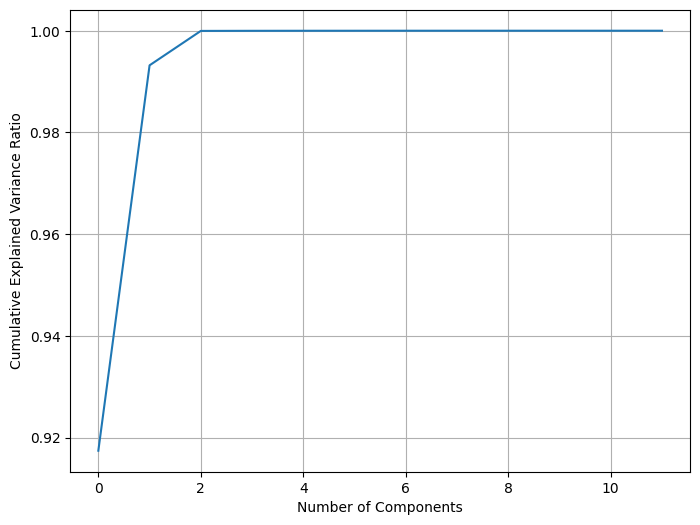

In [5]:
# Init PCA object
pca = PCA()
# Fit the PCA to your data
pca.fit(x)
# Plot cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

Best Parameters for k%: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
Feature ranking for k%:
1. Feature contact%: 0.39461204409599304
2. Feature swstr%: 0.24497687816619873
3. Feature o-contact%: 0.10928461700677872
4. Feature z-contact%: 0.0635751485824585
5. Feature pitching+: 0.06158265843987465
6. Feature stuff+: 0.040221139788627625
7. Feature cstr%: 0.026048054918646812
8. Feature z-swing%: 0.014964556321501732
9. Feature o-swing%: 0.012741814367473125
10. Feature swing%: 0.011679928749799728
11. Feature zone%: 0.011625982820987701
12. Feature location+: 0.008687248453497887


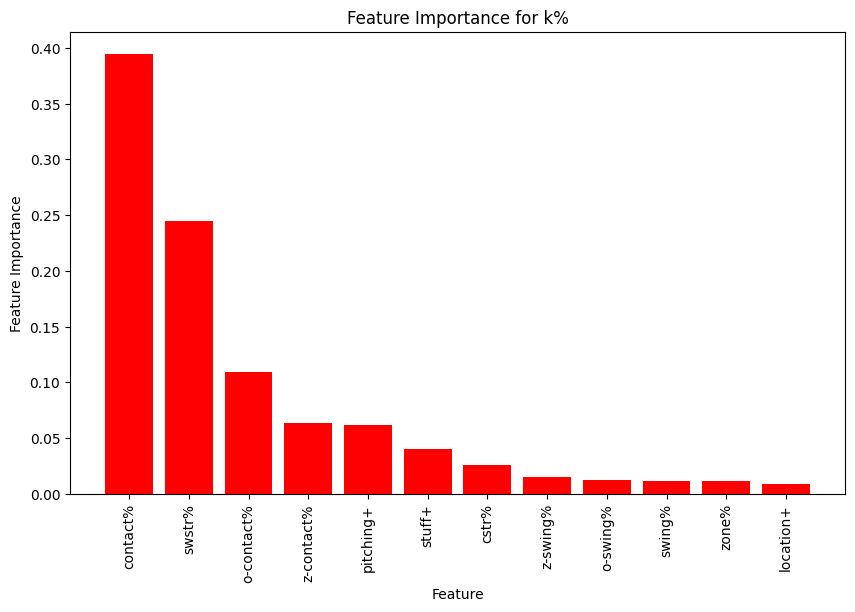

Best Parameters for bb%: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Feature ranking for bb%:
1. Feature location+: 0.3787331283092499
2. Feature swing%: 0.1310715526342392
3. Feature o-swing%: 0.10002217441797256
4. Feature cstr%: 0.08609073609113693
5. Feature contact%: 0.05978678539395332
6. Feature pitching+: 0.046789009124040604
7. Feature z-swing%: 0.03941131383180618
8. Feature zone%: 0.03469313681125641
9. Feature z-contact%: 0.03393034264445305
10. Feature o-contact%: 0.033550817519426346
11. Feature stuff+: 0.03185156360268593
12. Feature swstr%: 0.024069400504231453


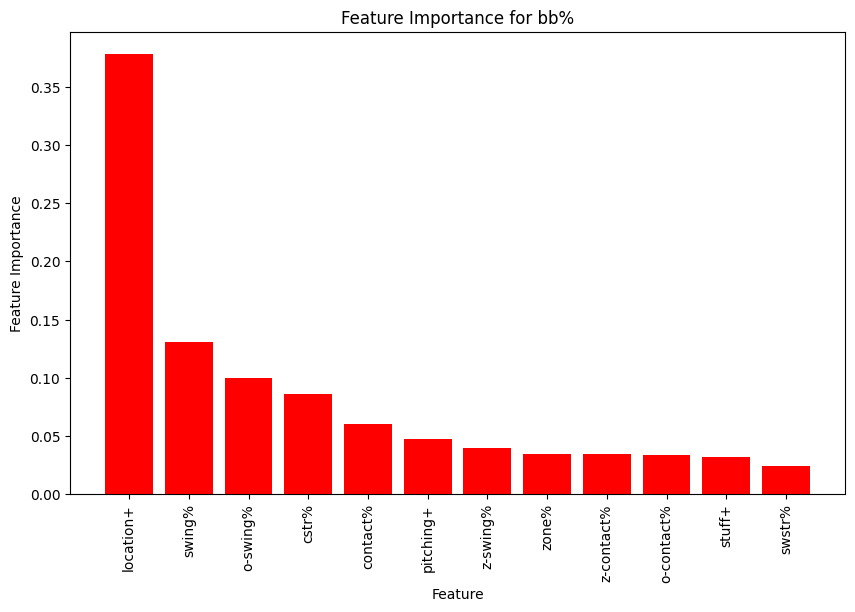

In [6]:
# Dictionary to hold models for each target variable
models = {}
################################ XGB REGRESSION CODE ##############################################################
# Initialize XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'max_depth': [3, 6, 9],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': [0, 0.1, 0.3],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.3]  # L2 regularization term on weights
}


# List of target variable column names
target_columns = [k.name, bb.name]
feature_names = x.columns.tolist()
# Iterate over target columns
for target_column in target_columns:
    # Initialize GridSearchCV
    model_gridsearch = GridSearchCV(
        estimator=xgb_regressor,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,  # 5-fold cross-validation
        n_jobs=-1  # Use all available CPU cores
    )
    
    # Fit the grid search to the data for the current target column
    model_gridsearch.fit(x, df[target_column])
    
    # Store the best model in the dictionary
    models[target_column+'_xgb'] = model_gridsearch.best_estimator_

    # Print the best parameters found
    print(f"Best Parameters for {target_column}:", model_gridsearch.best_params_)
    # Get feature importances for the best model
    best_model = models[target_column+'_xgb']
    feats_value = best_model.feature_importances_

    # Get the indices of features sorted by importance
    feats = np.argsort(feats_value)[::-1]

    print(f"Feature ranking for {target_column}:")
    for i, idx in enumerate(feats):
        print(f"{i + 1}. Feature {feature_names[idx]}: {feats_value[idx]}")

    # Plot feature importance for the best model
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance for {target_column}")
    plt.bar(range(len(feature_names)), feats_value[feats], color="r", align="center")
    plt.xticks(range(len(feature_names)), [feature_names[idx] for idx in feats], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.show()
###########################################################################################################

In [7]:
# Fit models for both 'k%' and 'bb%' target variables
models['k%_poly'] = polynomial_learning(x, k, k.name)
models['bb%_poly'] = polynomial_learning(x, bb, bb.name)   

Best regressor for k%: Ridge
BEST SCORE for k%: 0.00046885460033793653
Coefficients: [ 0.00000000e+00  7.74122983e-01  2.84600613e-04  5.55587447e-04
  1.80667191e-03 -2.01182712e-01 -3.56240764e-02  5.73939660e-02
  9.66707962e-02 -3.58296810e-02 -6.83989954e-01  2.03277509e-02
  3.94950326e-01]
Best training parameters for k%:  {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Best regressor for bb%: Lasso
BEST SCORE for bb%: 0.00012876738629861745
Coefficients: [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.72596103e-06 -3.5990475

C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e-02, tolerance: 2.339e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e-02, tolerance: 2.339e-05
  model = cd_fast.enet_coordinate_descent(


In [8]:
df_test = pd.read_csv("test.csv")
df_test = split_data(df_test)
x_test = pd.concat([df_test['swstr%'], df_test.loc[:,'stuff+':'cstr%']],axis=1)
k_test= df_test['k%']
bb_test = df_test['bb%']

predictions_df = pd.DataFrame(index=x_test.index)

for name,model in models.items():
    if 'k%' in name:
        test_data = k_test
    elif 'bb%' in name:
        test_data = bb_test
    else:
        continue  # Skip models not related to 'k%' or 'bb%'
    y_preds = evaluate_model(model, x_test, test_data, name)
    predictions_df[name] = y_preds

predictions_df["k%"] = k_test
predictions_df["bb%"] = bb_test
predictions_df = calculate_k_bb(predictions_df) 
# Write the DataFrame to a CSV file
predictions_df.to_csv('pred_k_bb%.csv')

Empty DataFrame
Columns: [team, ip, era, k/bb, avg, whip, babip, lob%, fip, ld%, gb%, fb%, iffb%, hr/fb, xfip, swstr%, k%, bb%, k-bb%, siera, e-f, fa-z (sc), barrel%, hardhit%, xera, stf+ fa, stuff+, location+, pitching+, o-swing%, z-swing%, swing%, o-contact%, z-contact%, contact%, zone%, cstr%, csw%, nameascii, playerid, mlbamid]
Index: []

[0 rows x 41 columns]
XGB MODEL
Evaluation metrics for k%_xgb:
Model Type XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=n

In [9]:
players_2021 = df.index.get_level_values('name')[df.index.get_level_values('season') == 2021].unique()
players_2022 = df.index.get_level_values('name')[df.index.get_level_values('season') == 2022].unique()
common_players = set(players_2021).intersection(players_2022)


players_2023 = df.index.get_level_values('name')[df.index.get_level_values('season') == 2023].unique()
common_players_2 = set(players_2022).intersection(players_2023)
print(common_players_2)
data_2021_x = df.loc[(2021, list(common_players)), :]
data_2022_y = df.loc[(2022, list(common_players)), :]
data_2022_x = df.loc[(2022, list(common_players_2)), :]
data_2023_y = df.loc[(2023, list(common_players_2)), :]
df_x = pd.concat([data_2021_x, data_2022_x])
df_y = pd.concat([data_2022_y, data_2023_y])

print(df_x,df_y)
x = pd.concat([df_x['swstr%'], df_x.loc[:,'stuff+':'cstr%']],axis=1)
k_yty = df_y['k%']
bb_yty = df_y['bb%']

k_x = models['k%_poly'].named_steps['poly'].transform(x)
preds_k = models['k%_poly'].named_steps['regressor'].predict(k_x)
preds_k_xgb = models['k%_xgb'].predict(x)
r2_kk = r2_score(k_yty,preds_k)
r2_kk_xgb = r2_score(k_yty,preds_k_xgb)

bb_x = models['bb%_poly'].named_steps['poly'].transform(x)
preds_bb = models['bb%_poly'].named_steps['regressor'].predict(bb_x)
preds_bb_xgb = models['bb%_xgb'].predict(x)
r2_bb = r2_score(bb_yty,preds_bb)
r2_bb_xgb = r2_score(bb_yty,preds_bb_xgb)

print("K% R2 YEAR TO YEAR: ", r2_score(k_yty,df_x['k%']))
print("K% Poly Model R2 YEAR TO YEAR: ", r2_kk)
print("K% XGB Model R2 YEAR TO YEAR: ", r2_kk_xgb)
print("BB% R2 YEAR TO YEAR: ", r2_score(bb_yty,df_x['bb%']))
print("BB% Poly Model R2 YEAR TO YEAR: ", r2_bb)
print("BB% XGB Model R2 YEAR TO YEAR: ", r2_kk)

{'Jose Quintana', 'Joe Musgrove', 'Matt Manning', 'Hunter Greene', 'Rich Hill', 'Kutter Crawford', 'Braxton Garrett', 'Spencer Strider', 'Nathan Eovaldi', 'Bailey Falter', 'Graham Ashcraft', 'Justin Verlander', 'Dane Dunning', 'Austin Gomber', 'Drew Smyly', 'Chris Flexen', 'Nestor Cortes', 'Merrill Kelly', 'Cristian Javier', 'Josiah Gray', 'Sonny Gray', 'Shane McClanahan', 'Joe Ryan', 'Kyle Hendricks', 'Luis Castillo', 'Tony Gonsolin', 'Kyle Freeland', 'Paul Blackburn', 'Zac Gallen', 'Corbin Burnes', 'Jon Gray', 'Tyler Wells', 'Alek Manoah', 'Adrian Houser', 'Gerrit Cole', 'Marcus Stroman', 'Jordan Montgomery', 'Mike Clevinger', 'Zack Greinke', 'Michael Wacha', 'Ranger Suárez', 'Kyle Gibson', 'Luis Severino', 'Cal Quantrill', 'Sandy Alcantara', 'Domingo Germán', 'Pablo López', 'Julio Urías', 'Nick Pivetta', 'Max Fried', 'Miles Mikolas', 'Charlie Morton', 'Lance Lynn', 'Noah Syndergaard', 'Brady Singer', 'Reid Detmers', 'Dylan Cease', 'Michael Kopech', 'Zach Davies', 'Carlos Rodón', 'Aa

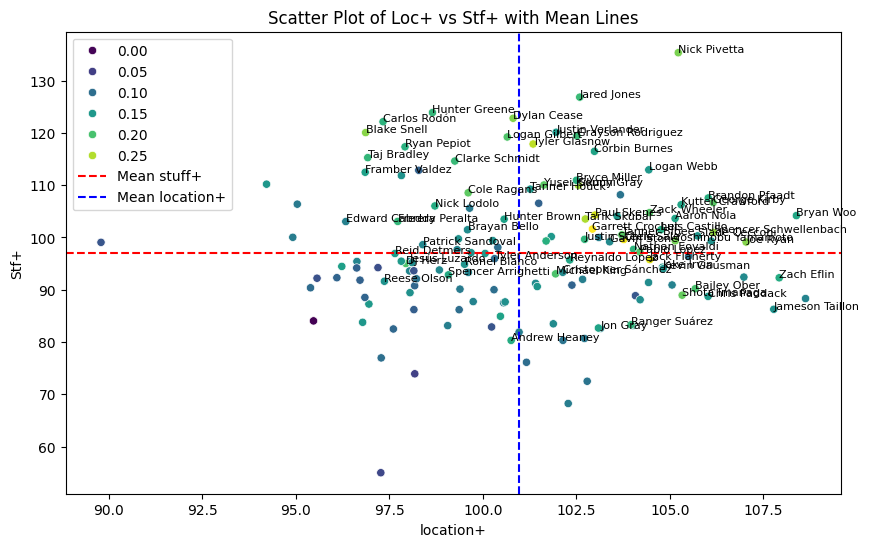

In [10]:
mean_1 = df_test['stuff+'].mean()
mean_2 = df_test['location+'].mean()
# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with color intensity based on another column and player names near the dots
sns.scatterplot(x='location+', y='stuff+', hue='k-bb%', data=df_test, palette='viridis')

# Plotting mean lines
plt.axhline(mean_1, color='red', linestyle='--', label='Mean stuff+')
plt.axvline(mean_2, color='blue', linestyle='--', label='Mean location+')

# Set labels and title
plt.xlabel('location+')
plt.ylabel('Stf+')
plt.title('Scatter Plot of Loc+ vs Stf+ with Mean Lines')

# Add legend
plt.legend()

# Filter rows where 'k-bb mods' is greater than 12 in predictions_df
filtered_rows = predictions_df[predictions_df['k-bb mods'] > predictions_df['k-bb mods'].mean()]

# Show player names above mean lines
for i, row in df_test.iterrows():
    index = (i[0], i[1])
    if index in filtered_rows.index:
        player_name = filtered_rows.loc[index, :].name  # Retrieve player name from filtered rows
        plt.text(row['location+'], row['stuff+'], player_name[1], fontsize=8, color='black', ha='left')

plt.show()

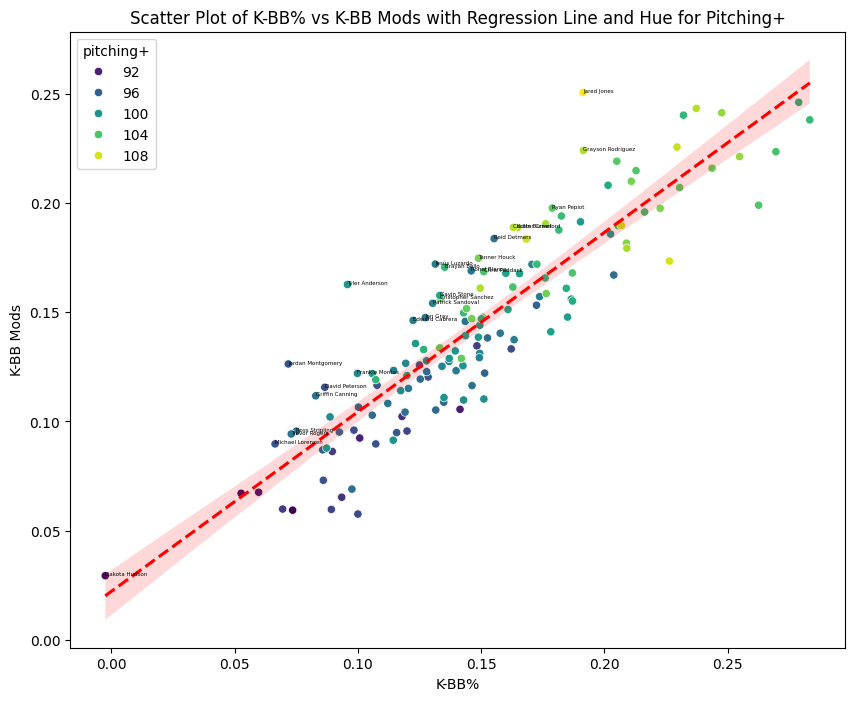

In [11]:
plt.figure(figsize=(10, 8))  # Adjust the size as needed

# Sort DataFrame based on the difference between 'k-bb mods' and 'k-bb%'
sorted_df = predictions_df.assign(diff=lambda x: x['k-bb mods'] - df_test['k-bb%']).sort_values(by='diff', ascending=False)

# Select the top 25 rows
top_25 = sorted_df.head(25)

# Plot scatter plot with hue
scatter = sns.scatterplot(x=df_test['k-bb%'], y=predictions_df['k-bb mods'], hue=df_test['pitching+'], palette='viridis')

# Overlay regression line y=x
sns.regplot(x=df_test['k-bb%'], y=predictions_df['k-bb mods'], scatter=False, line_kws={'color': 'red', 'linestyle': '--'})

# Display names of top 25
for name, _ in top_25.iterrows():
    plt.text(df_test.loc[name, 'k-bb%'], predictions_df.loc[name, 'k-bb mods'], name[1], fontsize=4, color='black')

# Add labels and title
plt.xlabel('K-BB%')
plt.ylabel('K-BB Mods')
plt.title('Scatter Plot of K-BB% vs K-BB Mods with Regression Line and Hue for Pitching+')
# Show plot
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler

# Prepare feature matrix X and target variable y
quick_cols = ['swstr%', 'contact%', 'o-contact%', 'stuff+','pitching+']
x_ks = df[quick_cols]
scaler = StandardScaler()
x_ks_scaled = scaler.fit_transform(x_ks)
y = df['k%']

quick_mod = polynomial_learning(x_ks_scaled,y,y.name)

x_test_ks = quick_mod["poly"].transform(scaler.transform(df_test[quick_cols]))
preds_ks = quick_mod["regressor"].predict(x_test_ks)

# Make predictions on the standardized test data
preds_ks = quick_mod["regressor"].predict(x_test_ks)

Best regressor for k%: Ridge
BEST SCORE for k%: 0.0005174999490407138
Coefficients: [ 0.         -0.00810778 -0.04841787  0.00400458  0.00172374  0.0153952 ]
Best training parameters for k%:  {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [13]:
# Compute regression metrics
mae = mean_absolute_error(df_test['k%'], preds_ks)
mse = mean_squared_error(df_test['k%'], preds_ks)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['k%'], preds_ks)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared of simplified model:", r2)

if r2 < 0.7:
    print("My Larger Poly K% model WINS!")
else:
    print("Turns out simpler is better")

Mean Absolute Error: 0.01897540450900461
Mean Squared Error: 0.000574456273438215
Root Mean Squared Error: 0.023967817452538624
R-squared of simplified model: 0.6990558469619592
My Larger Poly K% model WINS!


In [14]:
# Prepare feature matrix X and target variable y
quick_bb_cols = ['location+', 'o-swing%']  # Update to correct column names
x_bb = df[quick_bb_cols]
scaler = StandardScaler()
x_bb_scaled = scaler.fit_transform(x_bb)
y = df['bb%']

quick_bb = polynomial_learning(x_bb_scaled, y, y.name)

# Transform the test data
x_test_bb_scaled = scaler.transform(df_test[quick_bb_cols])  # Scale the test data
x_test_bb_poly = quick_bb["poly"].transform(x_test_bb_scaled)  # Apply polynomial transformation
preds_bb = quick_bb["regressor"].predict(x_test_bb_poly)  # Make predictions

Best regressor for bb%: Ridge
BEST SCORE for bb%: 0.00017858370358291595
Coefficients: [ 0.         -0.01352098 -0.00366384  0.00121818  0.00128141 -0.00115445]
Best training parameters for bb%:  {'alpha': 5, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [15]:
# Compute regression metrics
mae = mean_absolute_error(df_test['bb%'], preds_bb)
mse = mean_squared_error(df_test['bb%'], preds_bb)
rmse = np.sqrt(mse)
r2_bb = r2_score(df_test['bb%'], preds_bb)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared of simplified model:", r2_bb)

if r2_bb < 0.66:
    print("My Larger Poly BB% model WINS!")
else:
    print("Turns out simpler is better")

Mean Absolute Error: 0.00931832126089318
Mean Squared Error: 0.00012820956557483732
Root Mean Squared Error: 0.011322966288691198
R-squared of simplified model: 0.6966496796754593
Turns out simpler is better


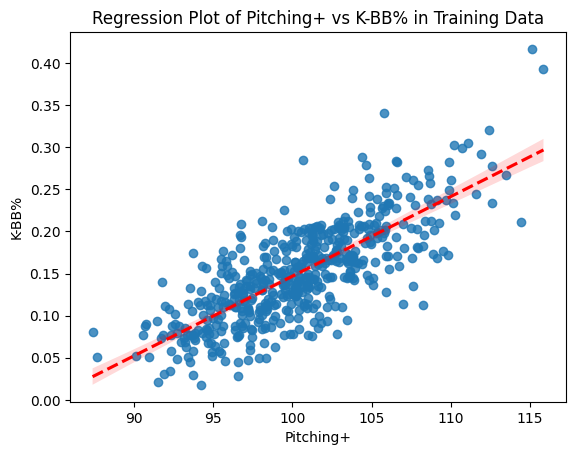

Slope: 0.00944900779138633
Correlation coefficient (r): 0.7674558937841368
P-value:  5.155009276054394e-104


In [16]:
# Plot regression plot
sns.regplot(x=df['pitching+'], y=df['k-bb%'], line_kws={'color': 'red', 'linestyle': '--'})

# Add labels and title
plt.ylabel('K-BB%')
plt.xlabel('Pitching+')
plt.title('Regression Plot of Pitching+ vs K-BB% in Training Data')

# Show plot
plt.show()

from scipy.stats import linregress

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['pitching+'],df['k-bb%'])

# Print slope and correlation coefficient
print("Slope:", slope)
print("Correlation coefficient (r):", r_value)
print("P-value: ", p_value)


In [17]:
pitch_preds = df_test['pitching+']*slope + intercept
print("R2 SCORE Pitching+ K-BB% : ", r2_score(df_test["k-bb%"],pitch_preds))

R2 SCORE Pitching+ K-BB% :  0.472773950960636
